In [89]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import SystemMessage, ToolMessage, BaseMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama

In [90]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [91]:
@tool
def add(num1: int, num2: int):
    """This function add two numbers together"""
    sum = num1 + num2
    return sum

In [92]:
tools = [add]

In [93]:
llm = ChatOllama(model = 'qwen2.5').bind_tools(tools)

In [94]:
def llm_node(state: AgentState) -> AgentState:
    print("\n\nSTATE: ", state)
    system_prompt = SystemMessage(["You are helfull assistant that answers the user's question accurately."])
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [98]:
def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "tool_call"

In [99]:
graph = StateGraph(AgentState)
graph.add_node("llm", llm_node)

tool_node = ToolNode(tools = tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("llm")
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        "tool_call": "tools",
        "end": END
    }
)

graph.add_edge("tools", "llm")
agent = graph.compile()

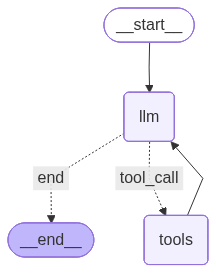

In [100]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [101]:
final_state = agent.invoke({"messages": "add 2 + 3"})



STATE:  {'messages': [HumanMessage(content='add 2 + 3', additional_kwargs={}, response_metadata={}, id='8bfa8177-332f-490e-ad96-16726aa7c0fa')]}


STATE:  {'messages': [HumanMessage(content='add 2 + 3', additional_kwargs={}, response_metadata={}, id='8bfa8177-332f-490e-ad96-16726aa7c0fa'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-12-28T15:45:28.637869523Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6924491446, 'load_duration': 3189225056, 'prompt_eval_count': 170, 'prompt_eval_duration': 873472462, 'eval_count': 27, 'eval_duration': 2851014037, 'logprobs': None, 'model_name': 'qwen2.5', 'model_provider': 'ollama'}, id='lc_run--1f44b365-7a01-4400-96ab-280ada8cd15a-0', tool_calls=[{'name': 'add', 'args': {'num1': 2, 'num2': 3}, 'id': 'bb846756-ccbc-47d5-a1f6-1f6d4c7b9231', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 27, 'total_tokens': 197}), ToolMessage(content='5', name='add', 

In [103]:
print(final_state)

{'messages': [HumanMessage(content='add 2 + 3', additional_kwargs={}, response_metadata={}, id='8bfa8177-332f-490e-ad96-16726aa7c0fa'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-12-28T15:45:28.637869523Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6924491446, 'load_duration': 3189225056, 'prompt_eval_count': 170, 'prompt_eval_duration': 873472462, 'eval_count': 27, 'eval_duration': 2851014037, 'logprobs': None, 'model_name': 'qwen2.5', 'model_provider': 'ollama'}, id='lc_run--1f44b365-7a01-4400-96ab-280ada8cd15a-0', tool_calls=[{'name': 'add', 'args': {'num1': 2, 'num2': 3}, 'id': 'bb846756-ccbc-47d5-a1f6-1f6d4c7b9231', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens': 27, 'total_tokens': 197}), ToolMessage(content='5', name='add', id='9f3898b0-6135-41b1-8025-0e2bfbb49d04', tool_call_id='bb846756-ccbc-47d5-a1f6-1f6d4c7b9231'), AIMessage(content='The result of adding 2 and 3 together is 

In [102]:
for msg in final_state["messages"]:
    if isinstance(msg, AIMessage):
        print(msg.content)


The result of adding 2 and 3 together is 5.
